In [5]:
######### Clustering via gap statistic #############
cv.test = function(x,y) {
  CV = sqrt(chisq.test(x, y, simulate.p.value = TRUE)$statistic /
              (length(x) * (min(length(unique(x)),length(unique(y))) - 1)))
  return(as.numeric(CV))
}

anova.test = function(x,y) {
  glm.fit <- glm(as.integer(y)~x,family = poisson(link = "log"))
  library(heplots)
  model.aov <- aov(glm.fit)
  etasq.x = etasq(model.aov, partial = TRUE)
  return(sqrt(etasq.x$`Partial eta^2`)[1])
}

corcatnum = function(numfeatures,catfeatures){
  cmatrix <- matrix(sample(-99,nrow(catfeatures)*nrow(numfeatures),T),ncol=nrow(numfeatures))
  rownames(cmatrix) = rownames(catfeatures)
  colnames(cmatrix) = rownames(numfeatures)
  ncat = dim(catfeatures)[1]
  nnum = dim(numfeatures)[1]
  for(i in 1:ncat){
    for(j in 1:nnum){
      testobj = kruskal_test(as.numeric(numfeatures[rownames(numfeatures)[j],]) ~ 
                             as.factor(catfeatures[rownames(catfeatures)[i],]))
      cmatrix[rownames(catfeatures)[i],rownames(numfeatures)[j]] = 1 - pvalue(testobj)
      
        
    }
  }
  return(cmatrix)
}

corbothcat = function(catfeatures){
  catmatrix <- matrix(sample(0,nrow(catfeatures)*nrow(catfeatures),T),ncol=nrow(catfeatures))
  rownames(catmatrix) = rownames(catfeatures)
  colnames(catmatrix) = rownames(catfeatures)
  ncat = dim(catfeatures)[1]
  for(i in 1:ncat){
    for(j in 1:ncat){
      if(i != j){
        testobj = chisq_test(as.factor(catfeatures[rownames(catfeatures)[i],]) ~ 
                               as.factor(catfeatures[rownames(catfeatures)[j],]))
        catmatrix[rownames(catfeatures)[i],rownames(catfeatures)[j]] = 1 - pvalue(testobj)
      }
      else{
        catmatrix[rownames(catfeatures)[i],rownames(catfeatures)[j]] = 1
      }
    }
  }
  return(catmatrix)
}


association = function(featmatrix,typevar){
  amatrix <- matrix(sample(0,nrow(feat.matrix)*nrow(feat.matrix),T),ncol=nrow(feat.matrix))
  rownames(amatrix) = rownames(feat.matrix)
  colnames(amatrix) = rownames(feat.matrix)
  numfeatures = feat.matrix[which(typevar == "numeric"),]
  class(numfeatures) = "numeric"
  pnum = cor.mtest(as.matrix(t(numfeatures)),method = c("spearman"), exact = FALSE)
  amatrix[rownames(numfeatures),rownames(numfeatures)] = (1 - pnum$p)
  # p-value using Spearman done for the numerical features and assigned to assoc matrix
  catfeatures = feat.matrix[which(typevar == "categorical"),]
  if(length(which(typevar == "categorical")) > 0)
  {
    cnummatrix = corcatnum(numfeatures,catfeatures)
    amatrix[rownames(catfeatures),rownames(numfeatures)] = cnummatrix
    amatrix[rownames(numfeatures),rownames(catfeatures)] = t(cnummatrix)
  }
  # Anova eta squared of the categorical and numerical done.
  if(length(which(typevar == "categorical")) > 1)
  {
    catmatrix = corbothcat(catfeatures)
    amatrix[rownames(catfeatures),rownames(catfeatures)] = catmatrix
    amatrix[rownames(catfeatures),rownames(catfeatures)] = t(catmatrix)
  }
  return (amatrix)
}

In [7]:
library(coin)
library(cluster)
library(stats)
library(factoextra)
set.seed(123)
library(dplyr)
library(corrplot)

In [ ]:
setwd("C:/Users/meghanam/Desktop/Work/Adobe/")


feat.matrix = readRDS("features_mamm.RDS")
typevar = readRDS("typevar_mamm.RDS")
feat.matrix = t(feat.matrix)
assocmatrix = association(feat.matrix,typevar)
#saveRDS(assocmatrix,"assocmatrix_mamm.RDS")
assocmatrix = readRDS("assocmatrix_mamm.RDS")
corrplot(assocmatrix, hclust.method = "complete",order = "hclust", tl.cex= 1.5, 
         cl.cex = 1.2, is.corr = FALSE, addrect = 3, rect.col = "red", rect.lwd = "4")

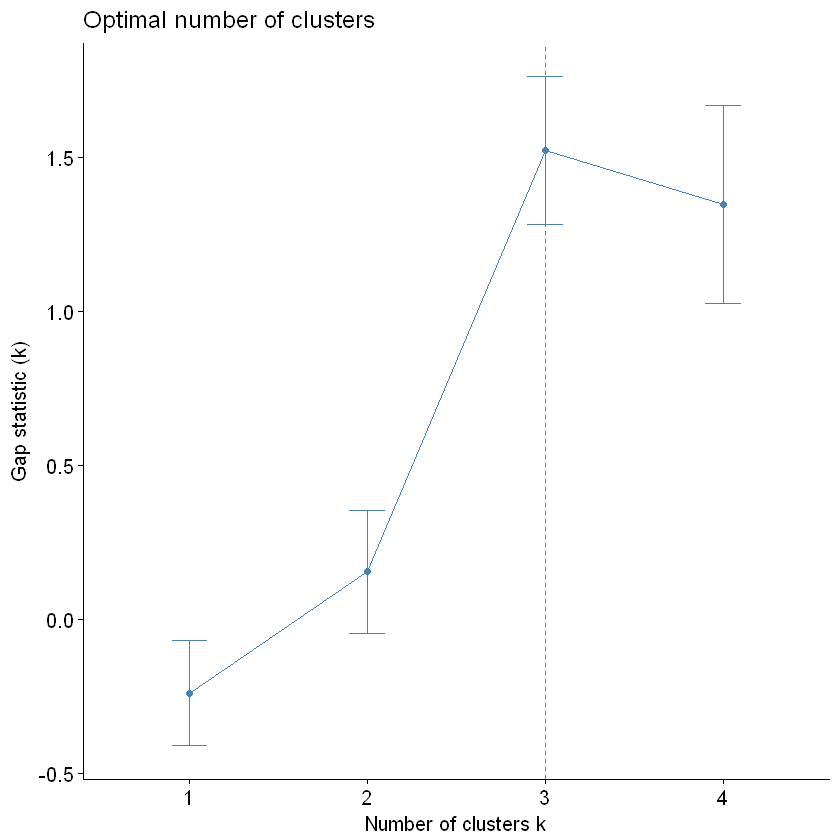

In [55]:
hclusCut <- function(x, k){
  hclust = hcut(as.dist(1 - assocmatrix), k = k, hc_method = "complete", isdiss = T, 
                hc_func = "hclust")
  return(list(cluster = hclust$cluster))
}

# gap_stat <- clusGap(feat.matrix, FUNcluster = hcut, K.max = 10, B = 100,
#                     hc_method = "complete", spaceH0 = "original",  hc_func = "hclust", 
#                     hc_metric = "pearson")

gap_stat <- clusGap(assocmatrix, FUNcluster = hclusCut, K.max = 4, B = 500,
                    d.power = 1,spaceH0 = "original")
# Plot gap statistic
fviz_gap_stat(gap_stat, 
              maxSE = list(method = "Tibs2001SEmax"))

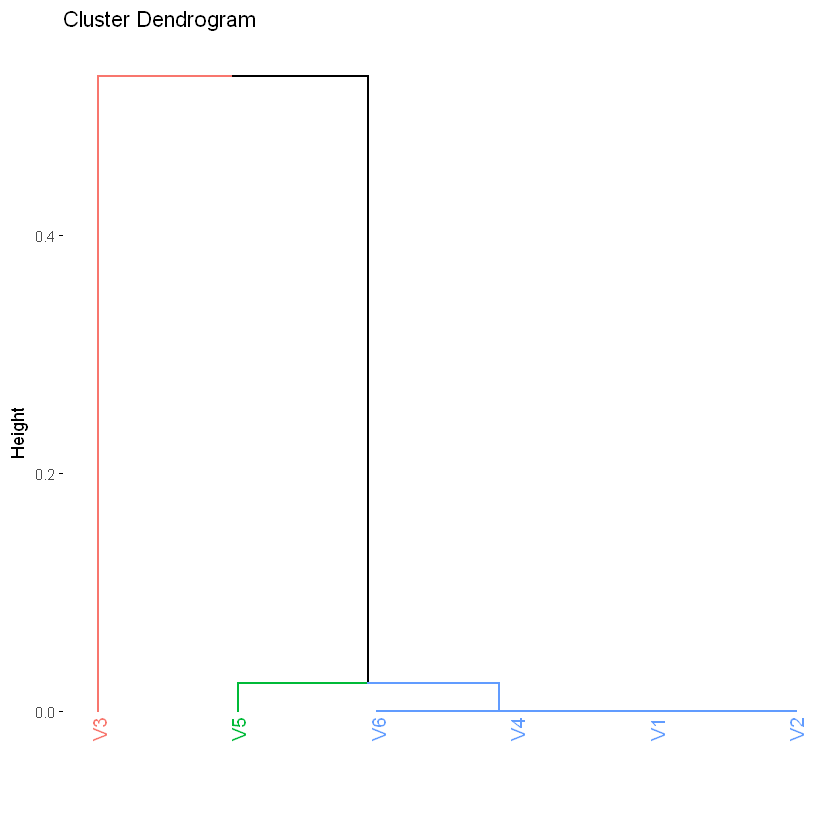

In [57]:
clust = hcut(as.dist(1 - assocmatrix), k = 3, hc_method = "complete", isdiss = T, hc_func = "hclust")
fviz_dend(clust)

In [67]:
groups = list()
for(i in seq(1:3))
{
  groups[[i]] = names(clust$cluster[clust$cluster == i]) 
}
contexts = expand.grid(groups)
saveRDS(contexts,"contextmamms.RDS")